# 1. Perkenalan

Nama : Gusti Ayu Dewi Puspa Kartikasari

Batch : FTDS-012

Dataset : COVID Face Mask Detection Dataset

Objective : Detecting face mask on image

# 2. Import Libraries

In [ ]:
#install split folders before import (if it isn't installed, import will be error)
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import libraries
from google.colab import drive
import pathlib
import numpy as np
import pandas as pd
import splitfolders
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow import keras
import os
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Install Kaggle library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Make a directory named `.kaggle` 
!mkdir ~/.kaggle

In [ ]:
# Copy the kaggle.json into this new directory 
!cp kaggle.json ~/.kaggle/

In [ ]:
# Change permission for this directory : 
!chmod 600 ~/.kaggle/kaggle.json

How to install kaggle and connect it,source: https://colab.research.google.com/drive/1TuUlbAs6x3NZyAJjbJdZVQKsXXHVWAWz?usp=sharing#scrollTo=81boI30gFe2s

# 3. Data Loading

In [ ]:
# Source dataset : https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset

!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

 95% 196M/207M [00:01<00:00, 141MB/s]
100% 207M/207M [00:01<00:00, 114MB/s]


In [ ]:
#unzip the dataset downloaded
!unzip ./covid-face-mask-detection-dataset.zip

Archive:  ./covid-face-mask-detection-dataset.zip
  inflating: New Masks Dataset/Test/Mask/2070.jpg  
  inflating: New Masks Dataset/Test/Mask/2072.jpg  
  inflating: New Masks Dataset/Test/Mask/2083.jpg  
  inflating: New Masks Dataset/Test/Mask/2085.jpg  
  inflating: New Masks Dataset/Test/Mask/2086.jpg  
  inflating: New Masks Dataset/Test/Mask/2110.jpg  
  inflating: New Masks Dataset/Test/Mask/2113.jpg  
  inflating: New Masks Dataset/Test/Mask/2114.jpeg  
  inflating: New Masks Dataset/Test/Mask/2130.jpg  
  inflating: New Masks Dataset/Test/Mask/2132.jpg  
  inflating: New Masks Dataset/Test/Mask/2135.jpg  
  inflating: New Masks Dataset/Test/Mask/2154.png  
  inflating: New Masks Dataset/Test/Mask/2158.png  
  inflating: New Masks Dataset/Test/Mask/2159.png  
  inflating: New Masks Dataset/Test/Mask/2160.png  
  inflating: New Masks Dataset/Test/Mask/2170.png  
  inflating: New Masks Dataset/Test/Mask/2172.png  
  inflating: New Masks Dataset/Test/Mask/2173.png  
  inflating: 

# 4. Exploratory Data Analysis (EDA)

In [ ]:
## Define path of each folder (train,test and validation)
test_path = '/content/New Masks Dataset/Test'
test_non_path = '/content/New Masks Dataset/Test/Mask'
test_mask_path = '/content/New Masks Dataset/Test/Mask'

train_path = '/content/New Masks Dataset/Train'
train_non_path = '/content/New Masks Dataset/Train/Non Mask'
train_mask_path = '/content/New Masks Dataset/Train/Mask'

validation_path = '/content/New Masks Dataset/Validation'
validation_non_path = '/content/New Masks Dataset/Validation/Non Mask'
validation_mask_path = '/content/New Masks Dataset/Validation/Mask'

The dataset used in this model has 3 different folder (train, test and validation) and each folder categorized the dataset based on its class (Non Mask and Mask). There is no inferece folder, further splitting needed to make data inference.

In [ ]:
#connecting the path of each dataset and category
test_pathc = pathlib.Path(test_path)
test_non_pathc = pathlib.Path(test_non_path)
test_mask_pathc = pathlib.Path(test_mask_path)

train_pathc = pathlib.Path(train_path)
train_non_pathc = pathlib.Path(train_non_path)
train_mask_pathc = pathlib.Path(train_mask_path)

validation_pathc = pathlib.Path(validation_path)
validation_non_pathc = pathlib.Path(validation_non_path)
validation_mask_pathc = pathlib.Path(validation_mask_path)

In [ ]:
#find categories in each file
class_names = np.array(sorted([item.name for item in test_pathc.glob('*')]))
print(class_names)

['Mask' 'Non Mask']


In [ ]:
#print the number of photo of each folder
print('Total test images     : ', len(list(test_non_pathc.glob('*')))+ len(list(test_mask_pathc.glob('*'))))
print('Total test-mask       : ', len(list(test_mask_pathc.glob('*'))))
print('Total test-non mask       : ', len(list(test_non_pathc.glob('*'))))
print('-'*10)
print('Total train images     : ',  len(list(train_non_pathc.glob('*')))+ len(list(train_mask_pathc.glob('*'))))
print('Total train-mask       : ', len(list(train_mask_pathc.glob('*'))))
print('Total train-non mask       : ', len(list(train_non_pathc.glob('*'))))
print('-'*10)
print('Total validation images     : ', len(list(validation_non_pathc.glob('*')))+ len(list(validation_mask_pathc.glob('*'))))
print('Total validation-mask       : ', len(list(validation_mask_pathc.glob('*'))))
print('Total validation-non mask       : ', len(list(validation_non_pathc.glob('*'))))

Total test images     :  100
Total test-mask       :  50
Total test-non mask       :  50
----------
Total train images     :  600
Total train-mask       :  300
Total train-non mask       :  300
----------
Total validation images     :  306
Total validation-mask       :  153
Total validation-non mask       :  153


Dataset test has 50 photo of person wearing a mask (Mask) and 50 person not wearing a mask (Non Mask). Dataset train has 300 Mask photo and 300 non mask photo. Validation dataset has 153 mask photo and 153 non mask photo. All data set has balanced number of sample for each category, therefore data imbalance handling isn't needed.

In [ ]:
#view random image function, source: https://colab.research.google.com/drive/1UZ9d0xYA5BBNRxRFZkAcFMaXaXy_Op4q?usp=sharing
def view_random_image(target_folder,target_class):
  target_fin_folder = target_folder + target_class
  random_image = random.sample(os.listdir(target_fin_folder), 1)
  img = mpimg.imread(target_fin_folder + "/" + random_image[0])
  print(f"image_shape:{img.shape} ; image_name:{random_image[0]} ; spectral: {img.ndim}")
  return img

In [ ]:
#print 10 name of train-mask dataset
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
for i in range(10):
  img = view_random_image(target_folder = '/content/New Masks Dataset/Train/',
                        target_class = 'Mask')

image_shape:(683, 1024, 3) ; image_name:0761.jpg ; spectral: 3
image_shape:(933, 700, 3) ; image_name:1493.jpg ; spectral: 3
image_shape:(926, 750, 3) ; image_name:1560.jpg ; spectral: 3
image_shape:(731, 750, 3) ; image_name:0561.jpg ; spectral: 3
image_shape:(963, 1024, 3) ; image_name:0499.jpg ; spectral: 3
image_shape:(553, 683, 3) ; image_name:0387.png ; spectral: 3
image_shape:(2002, 3000, 3) ; image_name:0003.jpg ; spectral: 3
image_shape:(750, 1000, 3) ; image_name:1609.jpg ; spectral: 3
image_shape:(1024, 757, 3) ; image_name:0498.jpg ; spectral: 3
image_shape:(579, 704, 3) ; image_name:0367.png ; spectral: 3


In [ ]:
#print 10 name of train-non mask dataset
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
for i in range(10):
  img = view_random_image(target_folder = '/content/New Masks Dataset/Train/',
                        target_class = 'Non Mask')

image_shape:(428, 320, 3) ; image_name:134.jpg ; spectral: 3
image_shape:(433, 327, 3) ; image_name:218.jpg ; spectral: 3
image_shape:(329, 207, 3) ; image_name:214.jpg ; spectral: 3
image_shape:(428, 320, 3) ; image_name:340.jpg ; spectral: 3
image_shape:(227, 222, 3) ; image_name:210.jpg ; spectral: 3
image_shape:(428, 320, 3) ; image_name:206.jpg ; spectral: 3
image_shape:(225, 225, 3) ; image_name:175.jpg ; spectral: 3
image_shape:(267, 189, 3) ; image_name:179.jpg ; spectral: 3
image_shape:(225, 225, 3) ; image_name:74.jpg ; spectral: 3
image_shape:(428, 320, 3) ; image_name:122.jpg ; spectral: 3


In [ ]:
#print 10 name of test-mask dataset
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
for i in range(10):
  img = view_random_image(target_folder = '/content/New Masks Dataset/Test/',
                        target_class = 'Mask')

image_shape:(618, 726, 3) ; image_name:2172.png ; spectral: 3
image_shape:(525, 894, 3) ; image_name:2191.png ; spectral: 3
image_shape:(621, 714, 3) ; image_name:2179.png ; spectral: 3
image_shape:(622, 716, 3) ; image_name:2300.png ; spectral: 3
image_shape:(582, 713, 3) ; image_name:2212.png ; spectral: 3
image_shape:(582, 713, 3) ; image_name:2212.png ; spectral: 3
image_shape:(612, 723, 3) ; image_name:2265.png ; spectral: 3
image_shape:(4256, 2832, 3) ; image_name:2072.jpg ; spectral: 3
image_shape:(520, 780, 3) ; image_name:2113.jpg ; spectral: 3
image_shape:(421, 893, 3) ; image_name:2190.png ; spectral: 3


In [ ]:
#print 10 name of test-non mask dataset
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
for i in range(10):
  img = view_random_image(target_folder = '/content/New Masks Dataset/Test/',
                        target_class = 'Non Mask')

image_shape:(600, 600, 3) ; image_name:real_01043.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_01038.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_01034.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_01073.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_01037.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_01062.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_01064.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_01068.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_01078.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_01080.jpg ; spectral: 3


In [ ]:
#print 10 name of validation-mask dataset
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
for i in range(10):
  img = view_random_image(target_folder = '/content/New Masks Dataset/Validation/',
                        target_class = 'Mask')

image_shape:(598, 647, 3) ; image_name:2602.png ; spectral: 3
image_shape:(637, 800, 3) ; image_name:1876.jpg ; spectral: 3
image_shape:(601, 400, 3) ; image_name:2012.jpg ; spectral: 3
image_shape:(560, 722, 3) ; image_name:2539.png ; spectral: 3
image_shape:(420, 630, 3) ; image_name:1902.jpg ; spectral: 3
image_shape:(671, 526, 3) ; image_name:2577.png ; spectral: 3
image_shape:(623, 716, 3) ; image_name:2595.png ; spectral: 3
image_shape:(406, 422, 3) ; image_name:1803.jpg ; spectral: 3
image_shape:(669, 526, 3) ; image_name:2538.png ; spectral: 3
image_shape:(621, 723, 3) ; image_name:2315.png ; spectral: 3


In [ ]:
#print 10 name of validation-non mask dataset
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
for i in range(10):
  img = view_random_image(target_folder = '/content/New Masks Dataset/Validation/',
                        target_class = 'Non Mask')

image_shape:(600, 600, 3) ; image_name:real_00056.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_00039.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_00065.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_00039.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_00088.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_00020.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_00999.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_00057.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_00065.jpg ; spectral: 3
image_shape:(600, 600, 3) ; image_name:real_00026.jpg ; spectral: 3


From the result of 6 cells above, it is known that the dataset had 3 different format of photo which are png, jpg, and jpeg. With also different size of photo for each of the sample (except test and validation non mask) but exact same spectrum (spectral 3: is defined as RGB spectrum) accross the dataset.


image_shape:(480, 910, 3) ; image_name:0091.jpg ; spectral: 3


(-0.5, 909.5, 479.5, -0.5)

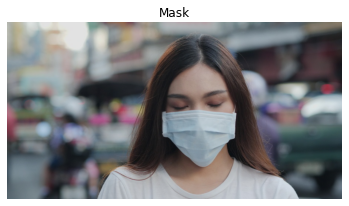

In [ ]:
#print a random image of train-mask dataset
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
targetcls = 'Mask'
img = view_random_image(target_folder = '/content/New Masks Dataset/Train/',
                        target_class = targetcls)
plt.imshow(img)
plt.title(targetcls)
plt.axis("off")

image_shape:(217, 232, 3) ; image_name:79.jpg ; spectral: 3


(-0.5, 231.5, 216.5, -0.5)

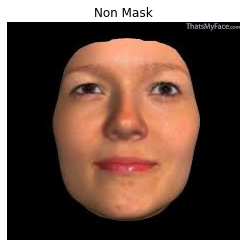

In [ ]:
#print a random image of train-mask dataset
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
targetcls = 'Non Mask'
img = view_random_image(target_folder = '/content/New Masks Dataset/Train/',
                        target_class = targetcls)
plt.imshow(img)
plt.title(targetcls)
plt.axis("off")

It is seen from the random sample above that mask class has a characteristic of color where there is skin tone color surounded by other color as hair above a monotone (blue, white, or other color) that identified as mask. If there is no monotone colored area below skin color and hair color, the picture may clasified as non mask. But there are different color of mask and the shape is also different, this may be a challenge for the model to identify the character of a mask. 

# 5. Data Preprocessing

In [ ]:
#do a split folder for data inference, 96% as train set and 4% for inference
#source: https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets
input_folder = "/content/New Masks Dataset/Train"
output = "/content/New Masks Dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.96, .04))

Copying files: 600 files [00:00, 2072.90 files/s]


In [ ]:
#setting new path for train after splitting
train_path = '/content/New Masks Dataset/train'

In [ ]:
#prepare imagedatagenerator for train dataset
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
tf.random.set_seed(15)

#preprocess data for validation and test
validation_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

#augmented object
train_datagen_augmented = ImageDataGenerator(rescale=1/255.0,
                                             rotation_range=0.3,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip = True,
                                             zoom_range=0.1)


these parameter for train image data generator are made for
rescale: to convert color matrix to 255
rotation range: it is to make variety for mask shape, let the model learn the shape is not majority in a reactabgle shape.
width shift and height shift: to ensure that the mask not alywas in the center of the photo.
Horizontal flip: vary the position of mask (if the person is looking to side)
vertical flip isn't used to ensure that the model can caught the pattern of mask hwich always used in mouth-nose area (if its verticaly flipped it can be identified mask is also used in above the eye area.
Zoom_range to caught the variety in masker size.

In [ ]:
#use flow from directory as input processing before put it into model
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
test_data = test_datagen.flow_from_directory(test_path,
                                               batch_size=16,
                                               class_mode='categorical',
                                               target_size=(224, 224),
                                               shuffle = False)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_path,
                                               batch_size=16,
                                               class_mode='categorical',
                                               target_size=(224, 224),
                                               seed=15)

valid_data = validation_datagen.flow_from_directory(validation_path,
                                               batch_size=16,
                                               class_mode='categorical',
                                               target_size=(224, 224),
                                               shuffle = False)

Found 100 images belonging to 2 classes.
Found 576 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


Batch size 16 and target size 224x224 is chosen because the epoch time isn't to high, therefore epoch with smaller size is possible to boost the result obtained by model and ensure uniform target size. Class_mode set as categorical, to ensure the output will be in 2 class with probability od each class.

For train, the shuffle paramater is left as True to shuffle the sample per epoch therefore made the model learn more without seeing the order of the sample. But for other than train, the shuflle is False, ensure that the predict ouput vs actual can be compared at the end.

In [ ]:
valid_data.class_indices

{'Mask': 0, 'Non Mask': 1}

The dataset with class = 0 is indicating a Mask and 1 as Non Mask. 

# 6. Model definition

#### First model

In [ ]:
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
#Conv2D model
model = Sequential()
model.add(Conv2D(32,3, activation ='relu', input_shape=(224, 224 ,3)))
model.add(MaxPool2D(2))

model.add(Conv2D(64,3, activation ='relu'))
model.add(MaxPool2D(2))

#flattened
model.add(Flatten())
model.add(Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=40)))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))


In [ ]:
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
#model compile
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001),
              metrics = [tf.keras.metrics.Recall()])

The base model is made by combining 2 layer of Conv2D to convert target to 2D object (for picture processing) with activation relu, each layer with 32 and 64 neurons and input shape is adjusted to target size in flow from directory cells 224x224 with RGB spectrum (3). Kernel initializer is glorot normal to draws samples from a truncated normal distribution centered on 0 and output activation is softmax with the number of ouput 2. (tried to use sigmoid but the code output is turned to error, therefore it is decided to use softmax) 

for model compile the loss using categorical crossentropy to know the loss between labels and predictions, optimizer: SGD with learning rate= 0.0001 to slow down the learn rate and prevent the result to jumping too far in the near to converge area, and the metrics used is recall as the priority of the model is to predict true Non Mask as many as possible.



#### Improvement model

In [ ]:
#Conv2D model
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
model_imp = Sequential()
model_imp.add(Conv2D(32,3, activation ='relu', input_shape=(224, 224 ,3)))
model_imp.add(MaxPool2D(2))

model_imp.add(Conv2D(64,3, activation ='relu'))
model_imp.add(MaxPool2D(2))

#flattened
model_imp.add(Flatten())
model_imp.add(Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=40)))
model_imp.add(tf.keras.layers.Dropout(rate=0.4))

model_imp.add(Dense(16))
model_imp.add(tf.keras.layers.Dropout(rate=0.4))
model_imp.add(keras.layers.BatchNormalization())
model_imp.add(keras.layers.Activation('relu'))

model_imp.add(Dense(2, activation = 'softmax'))

In [ ]:
#model compile
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
model_imp.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = [tf.keras.metrics.Recall()])

For the improvement model there are 3 layer added. Dropout is added with rate of 0.4 (this number isn't excessive because the active neuron still higher than the one in the layer after. Batch Normalization added for this model tends to have gradient vanishing and it is can be prevented using batchnormalization. Optimizer is also changed to Adam, to apply the addaptive learning rate owned by Adam.

#### Improvement model2

In [ ]:
#Conv2D model
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
model_imp2 = Sequential()
model_imp2.add(Conv2D(32,3, activation ='relu', input_shape=(224, 224 ,3)))
model_imp2.add(MaxPool2D(2))

model_imp2.add(Conv2D(64,3, activation ='relu'))
model_imp2.add(MaxPool2D(2))

#flattened
model_imp2.add(Flatten())
model_imp2.add(Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=40)))
model_imp2.add(Dense(16, activation = 'relu'))
model_imp2.add(Dense(2, activation = 'softmax'))

In [ ]:
#model compile
#source: https://colab.research.google.com/drive/1hK3CqsTka6bkOEtX6KyTHhTPFBfeEerg#scrollTo=stPh5IaYJeoV
model_imp2.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = [tf.keras.metrics.Recall()])

For the improvement model 2, the model is more simple than improvement model 1. There are no dropout layer but the optimizer is changed to Adam, to apply the adaptive learning rate owned by Adam.

# 7. Model Training

Model training will be done with model evaluation

# 8. Model Evaluation

#### Model evaluation for first model

In [ ]:
#define call backs
keras.backend.clear_session()
checkpoint_path = '/content/New Masks Dataset'
callback_param = [tf.keras.callbacks.EarlyStopping(monitor='recall',mode = 'max', patience=5,restore_best_weights=True),tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='recall', mode='max', save_best_only=True)]

#train model
his = model.fit(train_data_augmented, epochs = 50, validation_data = valid_data, callbacks = callback_param)

Epoch 1/50
36/36 [==============================] - 32s 507ms/step - loss: 0.6927 - recall: 0.5000 - val_loss: 0.7010 - val_recall: 0.5033
Epoch 2/50
36/36 [==============================] - 16s 461ms/step - loss: 0.6889 - recall: 0.5017 - val_loss: 0.7013 - val_recall: 0.4935
Epoch 3/50
36/36 [==============================] - 15s 425ms/step - loss: 0.6875 - recall: 0.4983 - val_loss: 0.7015 - val_recall: 0.4837
Epoch 4/50
36/36 [==============================] - 15s 433ms/step - loss: 0.6857 - recall: 0.4983 - val_loss: 0.6998 - val_recall: 0.4379
Epoch 5/50
36/36 [==============================] - 21s 596ms/step - loss: 0.6831 - recall: 0.5122 - val_loss: 0.7003 - val_recall: 0.4379
Epoch 6/50
36/36 [==============================] - 17s 462ms/step - loss: 0.6806 - recall: 0.5278 - val_loss: 0.7009 - val_recall: 0.4510
Epoch 7/50
36/36 [==============================] - 15s 425ms/step - loss: 0.6802 - recall: 0.5243 - val_loss: 0.6999 - val_recall: 0.4510
Epoch 8/50
36/36 [=========

Call backs are set in this model training. Where early stopping used to stop the train process if there is recall improvement in 5 next epoch, and model checkpoint is used to ensure if the training process forced to stop there will be back up of last best weights. Epoch is set at 50 and early stopping isn't activated because the recall always has improvement during the 5 tolerance epoch.

In [ ]:
#see the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 32)                5

(0.4, 1.0)

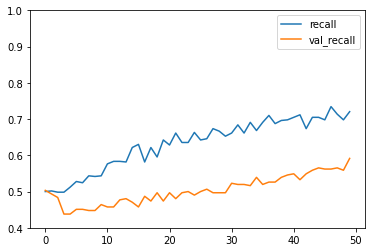

In [ ]:
#recall graph
metrics = pd.DataFrame(his.history)
metrics[["recall","val_recall"]].plot();
plt.gca().set_ylim(0.4, 1)

From the graph above it is analyzed that gradient exploding is prevented and gradient vanishing doesn't exist. Result obtained is progressing but underfit.

In [ ]:
#print model evaluation
model.evaluate(train_data_augmented)

36/36 [==============================] - 10s 284ms/step - loss: 0.6025 - recall: 0.7413


[0.6024895310401917, 0.7413194179534912]

In [ ]:
#make train dataset unshuffled for predict
train_data_augmented_nonshuffled = train_datagen_augmented.flow_from_directory(train_path,
                                               batch_size=16,
                                               class_mode='categorical',
                                               target_size=(224, 224),
                                               shuffle = False)

Found 576 images belonging to 2 classes.


this dataset is created for prediction to prevent shuffled result of prediction

In [ ]:
#do model prediction
y_train_pred = model.predict(train_data_augmented_nonshuffled)
y_test_pred = model.predict(test_data)

In [ ]:
#print accuracy score 
print('accuracy score train : ',accuracy_score(train_data_augmented_nonshuffled.classes,np.array(y_train_pred).argmax(axis=1)))
print('accuracy score test : ',accuracy_score(test_data.classes,np.array(y_test_pred).argmax(axis=1)))

accuracy score train :  0.7413194444444444
accuracy score test :  0.7


the gap between train and test is good, but for accuracy in 0.7 is a little bit low (underfit)

In [ ]:
#print classification report
print('-----------train-------------')
print(classification_report(train_data_augmented_nonshuffled.classes,np.array(y_train_pred).argmax(axis=1)))
print('-----------test-------------')
print(classification_report(test_data.classes,np.array(y_test_pred).argmax(axis=1)))

-----------train-------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       288
           1       0.71      0.81      0.76       288

    accuracy                           0.74       576
   macro avg       0.75      0.74      0.74       576
weighted avg       0.75      0.74      0.74       576

-----------test-------------
              precision    recall  f1-score   support

           0       0.76      0.58      0.66        50
           1       0.66      0.82      0.73        50

    accuracy                           0.70       100
   macro avg       0.71      0.70      0.70       100
weighted avg       0.71      0.70      0.70       100



In this model evaluation is focused on recall score in line 1, to evaluate success rate of detecting non-mask users (class 1) among actual non-mask user. The higher recall, the better the model performance.

In the first model, from recall in line 1 it is seen that the model is actually a goodfit for the dataset. But precission and overall performance is quite low. Proceed to confusion matrix.

Confusion Matrix


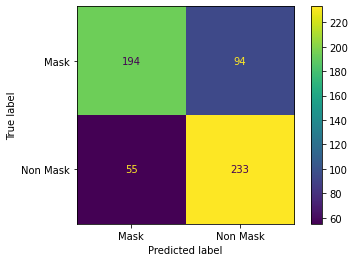

In [ ]:
#confusion matrix for train dataset
print('Confusion Matrix')
confmat = confusion_matrix(train_data_augmented_nonshuffled.classes,np.array(y_train_pred).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['Mask','Non Mask'])
disp.plot()
plt.show()

Confusion Matrix


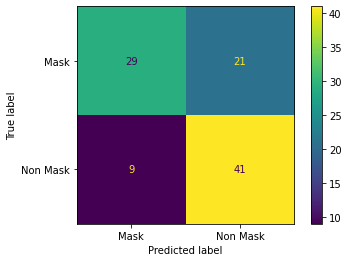

In [ ]:
#confusion matrix for test dataset
print('Confusion Matrix')
confmat = confusion_matrix(test_data.classes,np.array(y_test_pred).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['Mask','Non Mask'])
disp.plot()
plt.show()

From confussion matrix it is seen that the missprediction in this model is still quite large, especially in train where 55 person is misidentified as mask user.

#### Model evaluation for improvement model

In [ ]:
#define call backs
keras.backend.clear_session()
checkpoint_path = '/content/New Masks Dataset'
callback_param = [tf.keras.callbacks.EarlyStopping(monitor='recall_1', mode = 'max', patience=5,restore_best_weights=True),tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='recall_1', mode='max', save_best_only=True)]

#train model
his2 = model_imp.fit(train_data_augmented, epochs = 50, validation_data = valid_data, callbacks = callback_param)

Epoch 1/50
36/36 [==============================] - 18s 459ms/step - loss: 0.7927 - recall_1: 0.5035 - val_loss: 0.8524 - val_recall_1: 0.5098
Epoch 2/50
36/36 [==============================] - 16s 460ms/step - loss: 0.7312 - recall_1: 0.5660 - val_loss: 0.6697 - val_recall_1: 0.5294
Epoch 3/50
36/36 [==============================] - 16s 453ms/step - loss: 0.6300 - recall_1: 0.6389 - val_loss: 0.5846 - val_recall_1: 0.8824
Epoch 4/50
36/36 [==============================] - 16s 454ms/step - loss: 0.5057 - recall_1: 0.7708 - val_loss: 0.5583 - val_recall_1: 0.8725
Epoch 5/50
36/36 [==============================] - 16s 456ms/step - loss: 0.4593 - recall_1: 0.7760 - val_loss: 0.4697 - val_recall_1: 0.7876
Epoch 6/50
36/36 [==============================] - 17s 466ms/step - loss: 0.4554 - recall_1: 0.8003 - val_loss: 0.4200 - val_recall_1: 0.8889
Epoch 7/50
36/36 [==============================] - 15s 418ms/step - loss: 0.4677 - recall_1: 0.8003 - val_loss: 0.3568 - val_recall_1: 0.9183

Call backs are set in this model training. Where early stopping used to stop the train process if there is no recall improvement in 5 next epoch, and model checkpoint is used to ensure if the training process forced to stop there will be back up of last best weights. Epoch is set at 50 but the process stoped at 20, there is time saved because of early stopping callbacks.

In [ ]:
#see the model summary
model_imp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_3 (Dense)             (None, 32)               

(0.5, 1.0)

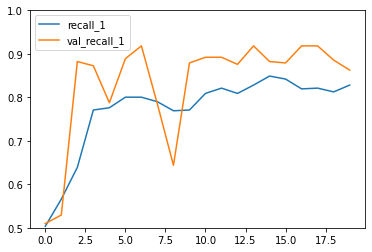

In [ ]:
#recall graph
metrics = pd.DataFrame(his2.history)
metrics[["recall_1","val_recall_1"]].plot();
plt.gca().set_ylim(0.5, 1)

From the graph above it is analyzed that there is a little bit gradient exploding in the middle but gradient vanishing is prevented. There is improvement from first model.

In [ ]:
#print model evaluation
model_imp.evaluate(train_data_augmented)

36/36 [==============================] - 10s 282ms/step - loss: 0.3241 - recall_1: 0.8750


[0.324095219373703, 0.875]

In [ ]:
#do model prediction
y_train_pred_imp = model_imp.predict(train_data_augmented_nonshuffled)
y_test_pred_imp = model_imp.predict(test_data)

In [ ]:
#print accuracy score 
print('accuracy score train : ',accuracy_score(train_data_augmented_nonshuffled.classes,np.array(y_train_pred_imp).argmax(axis=1)))
print('accuracy score test : ',accuracy_score(test_data.classes,np.array(y_test_pred_imp).argmax(axis=1)))

accuracy score train :  0.8836805555555556
accuracy score test :  0.86


the gap between train and test is good, and its score show a good performance (good fit)

In [ ]:
#print classification report
print('-----------train-------------')
print(classification_report(train_data_augmented_nonshuffled.classes,np.array(y_train_pred_imp).argmax(axis=1)))
print('-----------test-------------')
print(classification_report(test_data.classes,np.array(y_test_pred_imp).argmax(axis=1)))

-----------train-------------
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       288
           1       0.85      0.93      0.89       288

    accuracy                           0.88       576
   macro avg       0.89      0.88      0.88       576
weighted avg       0.89      0.88      0.88       576

-----------test-------------
              precision    recall  f1-score   support

           0       0.95      0.76      0.84        50
           1       0.80      0.96      0.87        50

    accuracy                           0.86       100
   macro avg       0.88      0.86      0.86       100
weighted avg       0.88      0.86      0.86       100



In the first improvement model, from recall in line 1 it is seen that the model is actually a goodfit for the dataset. It is a good recall both in test and train. Proceed to confussion matrix to see how many misprediction happened.

Confusion Matrix


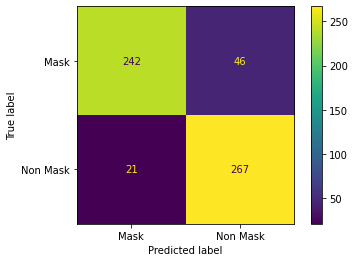

In [ ]:
#confusion matrix for train dataset
print('Confusion Matrix')
confmat = confusion_matrix(train_data_augmented_nonshuffled.classes,np.array(y_train_pred_imp).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['Mask','Non Mask'])
disp.plot()
plt.show()

Confusion Matrix


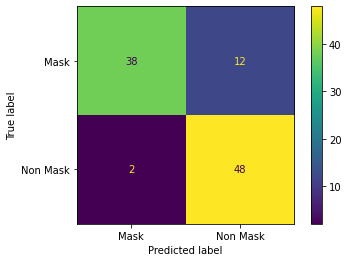

In [ ]:
#confusion matrix for test dataset
print('Confusion Matrix')
confmat = confusion_matrix(test_data.classes,np.array(y_test_pred_imp).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['Mask','Non Mask'])
disp.plot()
plt.show()

From confussion matrix in train it is seen that the missprediction in this model is still quite large, especially in train where 67 person is misidentified and test has 14 person misidentified.

#### Model evaluation for improvement model 2

In [ ]:
#define call backs
keras.backend.clear_session()
checkpoint_path = '/content/New Masks Dataset'
callback_param = [tf.keras.callbacks.EarlyStopping(monitor='recall_2', mode = 'max', patience=5,restore_best_weights=True),tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='recall_2', mode='max', save_best_only=True)]

#train model
his3 = model_imp2.fit(train_data_augmented, epochs = 50, validation_data = valid_data, callbacks = callback_param)

Epoch 1/50
36/36 [==============================] - 17s 459ms/step - loss: 1.0666 - recall_2: 0.6007 - val_loss: 0.4087 - val_recall_2: 0.8203
Epoch 2/50
36/36 [==============================] - 16s 442ms/step - loss: 0.4077 - recall_2: 0.8264 - val_loss: 0.4358 - val_recall_2: 0.7974
Epoch 3/50
36/36 [==============================] - 16s 453ms/step - loss: 0.3520 - recall_2: 0.8576 - val_loss: 0.3439 - val_recall_2: 0.8791
Epoch 4/50
36/36 [==============================] - 16s 443ms/step - loss: 0.2869 - recall_2: 0.8854 - val_loss: 0.2637 - val_recall_2: 0.9085
Epoch 5/50
36/36 [==============================] - 15s 417ms/step - loss: 0.3460 - recall_2: 0.8542 - val_loss: 0.3118 - val_recall_2: 0.8856
Epoch 6/50
36/36 [==============================] - 15s 416ms/step - loss: 0.3130 - recall_2: 0.8837 - val_loss: 0.2378 - val_recall_2: 0.9150
Epoch 7/50
36/36 [==============================] - 15s 415ms/step - loss: 0.2965 - recall_2: 0.8819 - val_loss: 0.2587 - val_recall_2: 0.9020

Call backs are set in this model training. Where early stopping used to stop the train process if there is recall improvement in 5 next epoch, and model checkpoint is used to ensure if the training process forced to stop there will be back up of last best weights. Epoch is set at 50 but the process stoped in 24, there is time saved because of early stopping callbacks.

In [ ]:
#see the model summary
model_imp2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_6 (Dense)             (None, 32)               

(0.5, 1.0)

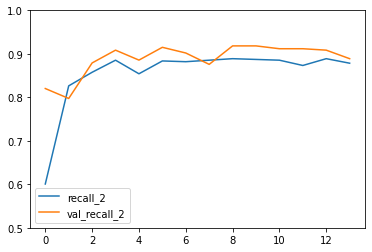

In [ ]:
#recall graph
metrics = pd.DataFrame(his3.history)
metrics[["recall_2","val_recall_2"]].plot();
plt.gca().set_ylim(0.5, 1)

From the graph above it is analyzed that gradient exploding is prevented and gradient vanishing doesn't exist. Result obtained is progressing and a goodfit.

In [ ]:
#do model prediction
y_train_pred_imp2 = model_imp2.predict(train_data_augmented_nonshuffled)
y_test_pred_imp2 = model_imp2.predict(test_data)

In [ ]:
#print accuracy score 
print('accuracy score train : ',accuracy_score(train_data_augmented_nonshuffled.classes,np.array(y_train_pred_imp2).argmax(axis=1)))
print('accuracy score test : ',accuracy_score(test_data.classes,np.array(y_test_pred_imp2).argmax(axis=1)))

accuracy score train :  0.8975694444444444
accuracy score test :  0.92


The gap between train and test is good, and the accuracy is higher than the last 2 models, it is an improvement.

In [ ]:
#print classification report
print('-----------train-------------')
print(classification_report(train_data_augmented_nonshuffled.classes,np.array(y_train_pred_imp2).argmax(axis=1)))
print('-----------test-------------')
print(classification_report(test_data.classes,np.array(y_test_pred_imp2).argmax(axis=1)))

-----------train-------------
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       288
           1       0.90      0.89      0.90       288

    accuracy                           0.90       576
   macro avg       0.90      0.90      0.90       576
weighted avg       0.90      0.90      0.90       576

-----------test-------------
              precision    recall  f1-score   support

           0       0.98      0.86      0.91        50
           1       0.88      0.98      0.92        50

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100



In the second improvement model, from recall in line 1 it is seen that the model is actually a goodfit for the dataset. Both recall in train and test is showing a good performance. The overall performance from precission and f1-score is also best over the 3 models evaluated.

Confusion Matrix


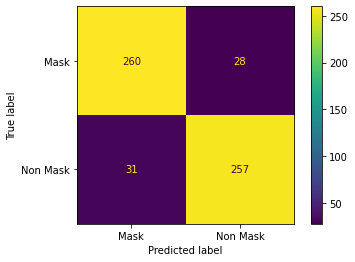

In [ ]:
#confusion matrix for train dataset
print('Confusion Matrix')
confmat = confusion_matrix(train_data_augmented_nonshuffled.classes,np.array(y_train_pred_imp2).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['Mask','Non Mask'])
disp.plot()
plt.show()

Confusion Matrix


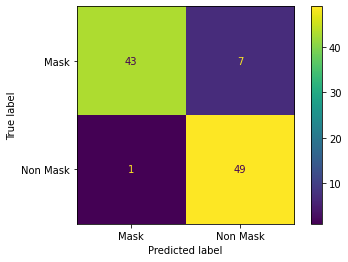

In [ ]:
#confusion matrix for test dataset
print('Confusion Matrix')
confmat = confusion_matrix(test_data.classes,np.array(y_test_pred_imp2).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['Mask','Non Mask'])
disp.plot()
plt.show()

From confussion matrix in train and test it is seen that the missprediction still exist in the model, especially in train where 59 person is misidentified and test has 9 person misidentified. But from the number of misprediction, this model has best result out of the 2 model.

Note: From overall evaluation (accuracy score, classification report and confussion matrix) of 3 different model, it is decided to use model improvement 2 for data inference. Because this model has best performance.

# 9. Model Inference

In [ ]:
#make inference data preprocesing for model input
inf_datagen = ImageDataGenerator(rescale=1/255.0)

inf_path = '/content/New Masks Dataset/val'

inf_data = inf_datagen.flow_from_directory(inf_path,
                                               batch_size=16,
                                               class_mode='categorical',
                                               target_size=(224, 224),
                                               shuffle = False)

Found 24 images belonging to 2 classes.


In [ ]:
#check the spectrum of dataset
inf_data.color_mode

'rgb'

in here it is proved that the spectrum of the sample dataset is RGB

In [ ]:
#print sample filenames in inference
inf_data.filenames

['Mask/0055.jpg',
 'Mask/0091.jpg',
 'Mask/0097.png',
 'Mask/0205.jpg',
 'Mask/0249.jpg',
 'Mask/0273.jpg',
 'Mask/0414.jpg',
 'Mask/0660.jpg',
 'Mask/0725.jpg',
 'Mask/0770.jpg',
 'Mask/1243.jpg',
 'Mask/1576.jpg',
 'Non Mask/11.jpg',
 'Non Mask/112.jpg',
 'Non Mask/114.jpg',
 'Non Mask/141.jpg',
 'Non Mask/151.jpg',
 'Non Mask/156.jpg',
 'Non Mask/170.jpg',
 'Non Mask/217.jpg',
 'Non Mask/228.jpg',
 'Non Mask/244.jpg',
 'Non Mask/326.jpg',
 'Non Mask/77.jpg']

Class :  Mask


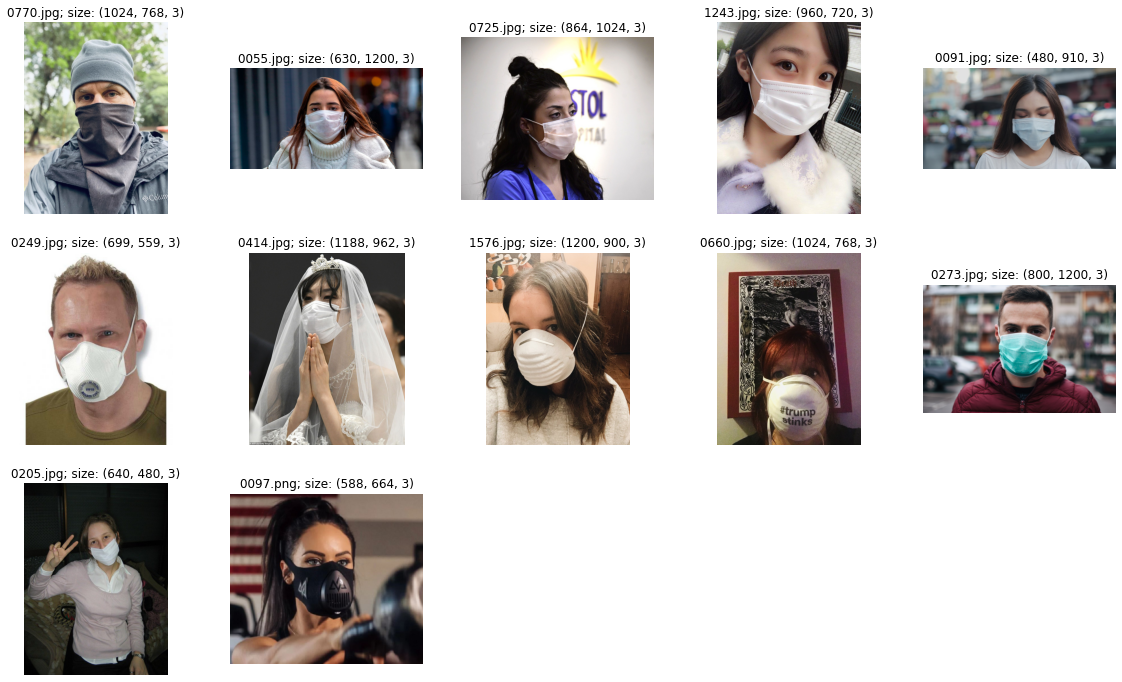

Class :  Non Mask


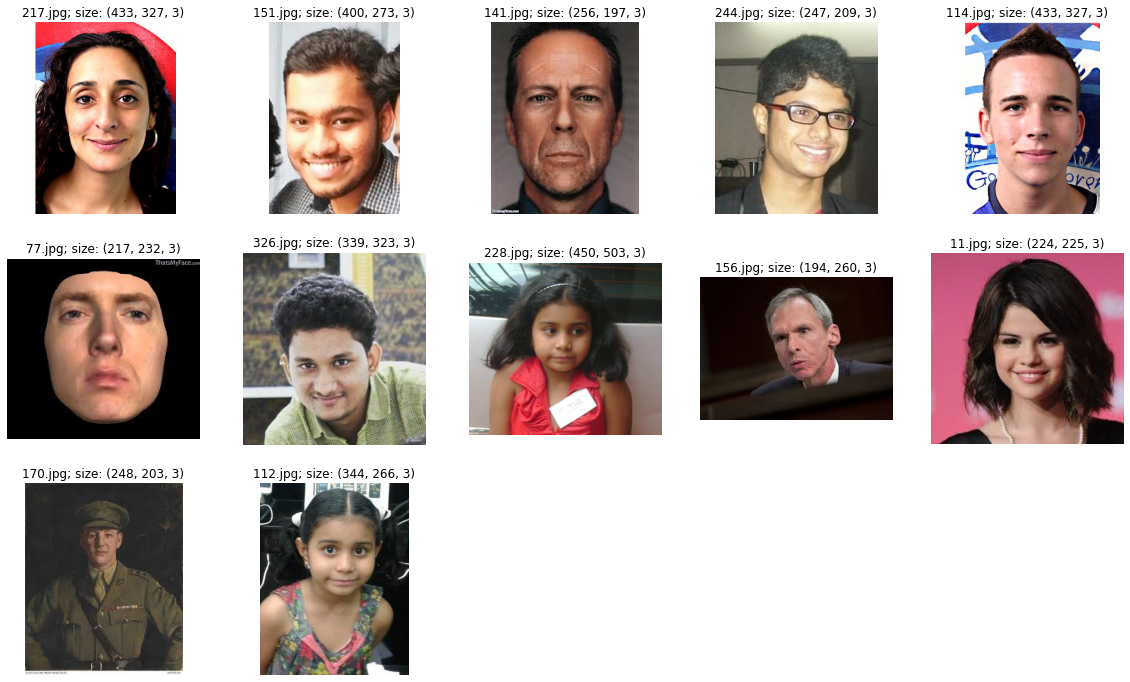

In [ ]:
#print all photo in inference dataset
#source: https://colab.research.google.com/drive/1TuUlbAs6x3NZyAJjbJdZVQKsXXHVWAWz?usp=sharing

target_inf_folder = '/content/New Masks Dataset/val/'

classes = {
    'Mask': 'Mask',
    'Non Mask' : 'Non Mask'
    
}

for i in classes.keys():
  folder_name = classes[i]
  fig = plt.figure(figsize=(20,12))
  columns = 5
  rows = 3
  print('Class : ', i)
  a = 1
  for index in os.listdir(target_inf_folder + i):
      fig.add_subplot(rows, columns, a)
      image = plt.imread(target_inf_folder + i + '/' + index)
      plt.imshow(image)
      plt.title(f'{index}; size: {image.shape}')
      plt.axis("off")
      a = a + 1
  plt.show()

There are 12 photos of mask category and 12 photos of non mask category with different size.

In [ ]:
#do model prediction
y_inf_pred_imp = model_imp2.predict(inf_data)

In [ ]:
#prediction result
y_inf_pred_imp

array([[9.8517758e-01, 1.4822343e-02],
       [8.5993940e-01, 1.4006065e-01],
       [9.2357093e-01, 7.6429062e-02],
       [9.3072635e-01, 6.9273591e-02],
       [6.4180142e-01, 3.5819861e-01],
       [9.0889519e-01, 9.1104776e-02],
       [5.8891147e-01, 4.1108853e-01],
       [9.7901958e-01, 2.0980405e-02],
       [9.3284327e-01, 6.7156702e-02],
       [8.2883477e-01, 1.7116521e-01],
       [7.6270515e-01, 2.3729487e-01],
       [9.4586253e-01, 5.4137405e-02],
       [5.1172656e-01, 4.8827344e-01],
       [5.8482443e-03, 9.9415177e-01],
       [5.2828499e-04, 9.9947172e-01],
       [2.0661922e-02, 9.7933805e-01],
       [2.4790212e-03, 9.9752098e-01],
       [1.0189822e-01, 8.9810175e-01],
       [6.3424140e-01, 3.6575860e-01],
       [5.8597320e-04, 9.9941409e-01],
       [7.0397072e-02, 9.2960298e-01],
       [7.5485893e-02, 9.2451406e-01],
       [2.0795308e-01, 7.9204696e-01],
       [2.8715860e-03, 9.9712843e-01]], dtype=float32)

In [ ]:
#relabeling the prediction result with 0 = Mask and 1 = Non Mask
res = np.array(y_inf_pred_imp).argmax(axis=1)
res = np.where(res == 0, 'Mask', 'Non Mask')
res

array(['Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask',
       'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Non Mask', 'Non Mask',
       'Non Mask', 'Non Mask', 'Non Mask', 'Mask', 'Non Mask', 'Non Mask',
       'Non Mask', 'Non Mask', 'Non Mask'], dtype='<U8')

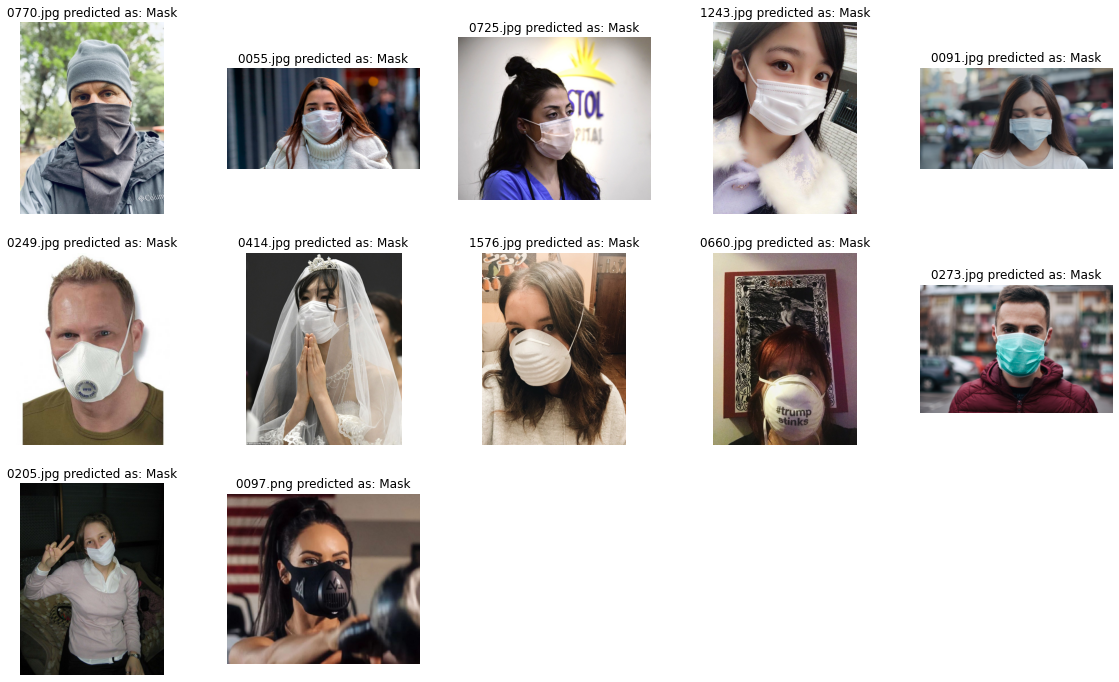

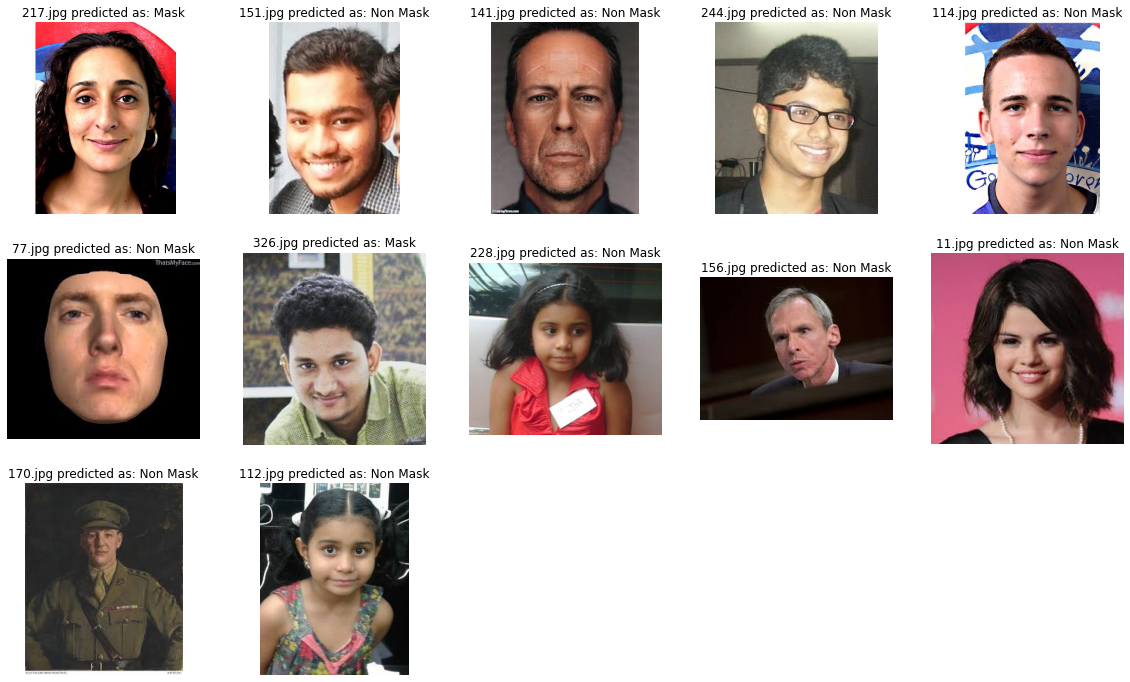

In [ ]:
#print photo and its predicted label
#source: https://colab.research.google.com/drive/1TuUlbAs6x3NZyAJjbJdZVQKsXXHVWAWz?usp=sharing
b = 0
for i in classes.keys():
  folder_name = classes[i]
  fig = plt.figure(figsize=(20,12))
  columns = 5
  rows = 3
  a = 1
  for index in os.listdir(target_inf_folder + i):
      fig.add_subplot(rows, columns, a)
      image = plt.imread(target_inf_folder + i + '/' + index)
      plt.imshow(image)
      plt.title(index + ' predicted as: '+ res[b])
      plt.axis("off")
      a = a + 1
      b = b + 1
  plt.show()

There is 2 missprediction, in 217.jpg, and 326.jpg. It can be seen that in 326.jpg, the color  of face is too light and detected as a mask, for 217.jpg the face may be detected as face printed mask. As in the train there is a photo of mask with a nose and mouth printed in it that make our model learned that some shape of face is also categorized as a mask. Below is the example of photo with face printed mask in train dataset.

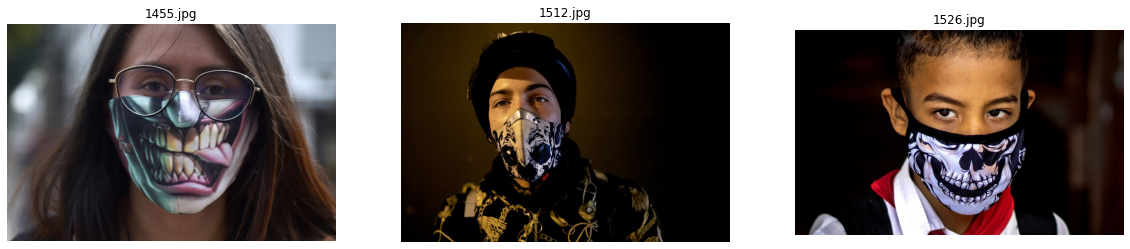

In [ ]:
fig = plt.figure(figsize=(20,12))
fig.add_subplot(1, 3, 1)
image = plt.imread('/content/New Masks Dataset/train/Mask/1455.jpg')
plt.imshow(image)
plt.title('1455.jpg')
plt.axis("off")

fig.add_subplot(1, 3, 2)
image = plt.imread('/content/New Masks Dataset/train/Mask/1512.jpg')
plt.imshow(image)
plt.title('1512.jpg')
plt.axis("off")

fig.add_subplot(1, 3, 3)
image = plt.imread('/content/New Masks Dataset/train/Mask/1526.jpg')
plt.imshow(image)
plt.title('1526.jpg')
plt.axis("off")

plt.show()


The future improvement may include brightness_range added in tf.keras.preprocessing.image.ImageDataGenerator. For the sample for training model, it is better to use a photo of non face printed mask. Because if the model learn that the mask is a non face printed pattern, the model will tend to predict a face printed mask as non mask user. It is better than predict an actual face as a mask (because face printed mask tell some face actually a mask). As our goal to predict actual non mask user as accurate as possible.

In [ ]:
target_inf_folder

'/content/New Masks Dataset/val/'

In [ ]:
#actual labels of inference data
inf_data.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [ ]:
#prediction result in labels
np.array(y_inf_pred_imp).argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1])

From the inference model it is obtained that the prediction result has only 2 missprediction out of 24 data. Therefore the accuracy of the model is 22/24 = 91.7% and this score is a good fit.

# 10. Model Saving

Model saving for front end and backend

In [ ]:
# drive.mount('/content/drive')

In [ ]:
# #navigasi ke home folder
# % cd /content/drive/MyDrive

In [ ]:
# #masuk folder kartun cnn
# % cd Colab Notebooks/pyHackative8/Phase 2/milestone

In [ ]:
# ! ls

In [ ]:
# #freeze model
# model_imp2.trainable = False

In [ ]:
# #do the model summary to prove that this model is no longer trainable
# model_imp2.summary()

In [ ]:
# #save model
# model_imp2.save("mask_detection")

# 11. Conclusion

From data loading and EDA:
- The dataset used in this model has 3 different folder (train, test and validation) and each folder categorized the dataset based on its class (Non Mask and Mask).
- All data set has balanced number of sample for each category, therefore data imbalance handling isn't needed.
- That the dataset had 3 different format of photo which are png, jpg, and jpeg. With also different size of photo for each of the sample (except test and validation non mask) but exact same spectrum (spectral 3: is defined as RGB spectrum) accross the dataset.

From data preprocessing:
- For image preprocessing, some parameters used as follows:
rescale: to convert color matrix to 255.
rotation range: it is to make variety for mask shape, let the model learn the shape is not majority in a reactangle shape.
width shift and height shift: to ensure that the mask not alywas in the center of the photo.
Horizontal flip: vary the position of mask (if the person is looking to side)
Note: vertical flip isn't used to ensure that the model can caught the pattern of mask hwich always used in mouth-nose area (if its verticaly flipped it can be identified mask is also used in above the eye area.
Zoom_range to caught the variety in masker size.
- Batch size 16 and target size 224x224 is chosen because the epoch time isn't to high, therefore epoch with smaller size is possible to boost the result obtained by model and ensure uniform target size.
- For train, the shuffle paramater is left as True to shuffle the sample per epoch therefore made the model learn more without seeing the order of the sample. 

From model definition:
- Base model:
a. Combining 2 layer of Conv2D to convert target to 2D object (for picture processing) with activation relu, each layer with 32 and 64 neurons and input shape is adjusted to target size in flow from directory cells 224x224 with RGB spectrum (3).
b. Kernel initializer is glorot normal to draws samples from a truncated normal distribution centered on 0.
c. Output activation is softmax with the number of ouput 2. (tried to use sigmoid but the code output is turned to error, therefore it is decided to use softmax)
d.Model compile: the loss using categorical crossentropy to know the loss between labels and predictions, optimizer: SGD with learning rate= 0.0001 to slow down the learn rate and prevent the result to jumping too far in the near to converge area, and the metrics used is recall as the priority of the model is to predict true Non Mask as many as possible

- Improvement model 1:
a. Use all of parameters in base model
b. 3 layer added: 2 dropout layer is added with rate of 0.4 and 1 Batch Normalization layer added for this model tends to have gradient vanishing and it is can be prevented using batchnormalization. 
c. Change optimizer: Optimizer is also changed to Adam, to apply the adaptive learning rate owned by Adam.

- Improvement model 2:
a. Use all of parameters in base model
b. only change optimizer: Optimizer changed to Adam, to apply the adaptive learning rate owned by Adam.


Model Evaluation:
- Base model: no gradient vanishing or gradient exploding, accuracy is low (underfit), from classification report: recall is good but other parameter is low, missprediction from this model is large.

- improvement model 1: no gradient vanishing or gradient exploding, accuracy is a goodfit and better than base model, from classification report: recall is high and other parameter is also good, missprediction from this model still quite large but better than base model.

- improvement model 2: no gradient vanishing or gradient exploding, accuracy is a goodfit and better than the last two model, from classification report: recall is high and other parameter is also good better than improvement model 2, missprediction number from this model is smaller than the two other model.

- From overall evaluation (accuracy score, classification report and confussion matrix) of 3 different model, it is decided to use model improvement 2 for data inference. Because this model has best performance.

Model inference:
- There are 12 photos of mask category and 12 photos of non mask category with different size.
-From the inference model it is obtained that the prediction result has only 2 missprediction out of 24 data. Therefore the accuracy of the model is 22/24 = 91.7% and this score is a good fit.
- Notes found from samples that mispredicted: photo brightness may affect the prediction result, and there are also several faces that predicted as a mask (a face printed mask) caused by Mask labelled samples in train that has a face printed mask. Therefore the model learn that several face pattern is actually a mask, while in the actual they are not a mask.

For further improvement:
- Try another parameter tunning for the model
- Try using functional model
- Adding brightness_range in preprocessing
- Make a constraint in choosing samples for training dataset. It is to use photos of non face printed mask. Because if the model learn that the mask is a 'non face printed pattern' area, the model will tend to predict a face printed mask as non mask user. It is better than the current dataset where the model predict an actual face as a mask (because face printed mask tell some face pattern actually a mask). As our goal to predict actual non mask user as accurate as possible.